In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# A futtatáshoz szükséges kód telepítése

In [ ]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install tf_slim lvis

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/:/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

In [3]:
%cd /content
! git clone https://github.com/gume/VITMMA10_OD.git

/content
Cloning into 'VITMMA10_OD'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 124 (delta 20), reused 123 (delta 19), pack-reused 0
Receiving objects: 100% (124/124), 13.96 MiB | 26.27 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
%cd /content/VITMMA10_OD
! git pull

# Képek és annotációk átalakítása

In [4]:
%cd /content/VITMMA10_OD

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python code/xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations
 
# Convert test folder annotation xml files to a single csv.
!python code/xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv
 
# Generate `train.record`
!python code/generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt
 
# Generate `test.record`
!python code/generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt

/content/VITMMA10_OD
Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`
Successfully converted xml to csv.
Successfully created the TFRecords: /content/VITMMA10_OD/data/annotations/train.record
Successfully created the TFRecords: /content/VITMMA10_OD/data/annotations/test.record


In [5]:
test_record_fname = '/content/VITMMA10_OD/data/annotations/test.record'
train_record_fname = '/content/VITMMA10_OD/data/annotations/train.record'
label_map_pbtxt_fname = '/content/VITMMA10_OD/data/annotations/label_map.pbtxt'

# Modell kiválasztása

https://github.com/tensorflow/models/tree/master/research/object_detection/g3doc

In [113]:
# Number of training steps.
num_steps = 1000 # 200000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'ssd_mobilenet_v2_quantized': {
        'model_name': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03',
        'pipeline_file': 'ssd_mobilenet_v2_quantized_300x300_coco.config',
        'batch_size': 12
    },
    'ssd_mobilenet_v1_fpn': {
        'model_name': 'ssd_mobilenet_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03',
        'pipeline_file': 'ssd_mobilenet_v1_fpn_coco.config',
        'batch_size': 12
    },
    'ssd_mobilenet_v1': {
        'model_name': 'ssd_mobilenet_v1_coco_2018_01_28',
        'pipeline_file': 'ssd_mobilenet_v1_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2_quantized'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']


# Model letöltése


In [118]:
! rm -rf /content/models/research/pretrained_model

In [120]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [121]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 204M
drwx------  2 303230 5000 4.0K Jan  4  2019 .
drwxr-xr-x 24 root   root 4.0K Nov 20 08:58 ..
-rw-------  1 303230 5000  93M Jan  4  2019 model.ckpt.data-00000-of-00001
-rw-------  1 303230 5000  68K Jan  4  2019 model.ckpt.index
-rw-------  1 303230 5000  20M Jan  4  2019 model.ckpt.meta
-rw-------  1 303230 5000 4.3K Jan  4  2019 pipeline.config
-rw-------  1 303230 5000  24M Jan  4  2019 tflite_graph.pb
-rw-------  1 303230 5000  68M Jan  4  2019 tflite_graph.pbtxt


In [122]:
DEST_DIR = "/content/models/research/pretrained_model"

fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
print(fine_tune_checkpoint)

pipeline_file = os.path.join(DEST_DIR, "pipeline.config")
os.rename(pipeline_file, os.path.join(DEST_DIR, "pipeline.config.original"))
print(pipeline_file)

/content/models/research/pretrained_model/model.ckpt
/content/models/research/pretrained_model/pipeline.config


In [123]:
import os
import re

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

pipeline_fname_original = os.path.join(DEST_DIR, "pipeline.config.original")
pipeline_fname = os.path.join(DEST_DIR, "pipeline.config")
assert os.path.isfile(pipeline_fname_original), '`{}` not exist'.format(pipeline_fname_original)

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname_original) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

Issue: https://github.com/tensorflow/models/issues/3794

In [124]:
%cd /content

model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

/content


# Tanítás

In [95]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [98]:
%tensorboard --logdir 'training/'

Reusing TensorBoard on port 6007 (pid 2990), started 0:04:13 ago. (Use '!kill 2990' to kill it.)

In [125]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W1120 08:59:08.992676 139821125216128 model_lib.py:793] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 1000
I1120 08:59:08.993005 139821125216128 config_util.py:552] Maybe overwriting train_steps: 1000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1120 08:59:08.993125 139821125216128 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I1120 08:59:08.993206 139821125216128 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I1120 08:59:08.993296 139821125216128 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W1120 08:59:08.993424 139821125216128 model_lib.py:809] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to_t

# Model elmentése

In [126]:
!rm -rf '/content/fine_tuned_model'

In [ ]:
output_directory = '/content/fine_tuned_model'
pipeline_fname = '/content/models/research/pretrained_model/pipeline.config.original'
last_model_path = '/content/models/research/pretrained_model/model.ckpt'


In [127]:
import re
import numpy as np

output_directory = '/content/fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)


training/model.ckpt-1000


In [128]:
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

Instructions for updating:
Please use `layer.__call__` method instead.
W1120 09:08:34.701262 139649736193920 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I1120 09:08:36.783597 139649736193920 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1120 09:08:36.821215 139649736193920 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1120 09:08:36.857226 139649736193920 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

In [129]:
# https://medium.com/tensorflow/training-and-serving-a-realtime-mobile-object-detector-in-30-minutes-with-cloud-tpus-b78971cf1193
# create the tensorflow lite graph
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path={pipeline_fname} \
    --trained_checkpoint_prefix='{last_model_path}' \
    --output_directory='{output_directory}' \
    --add_postprocessing_op=true

Instructions for updating:
Please use `layer.__call__` method instead.
W1120 09:09:05.270278 140034959189888 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I1120 09:09:07.345650 140034959189888 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1120 09:09:07.377057 140034959189888 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1120 09:09:07.405924 140034959189888 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

In [130]:
!echo "CONVERTING frozen graph to quantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_quantized.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

CONVERTING frozen graph to quantized TF Lite file...
2020-11-20 09:09:25.627042: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-20 09:09:25.631487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-20 09:09:25.631978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2020-11-20 09:09:25.632196: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-11-20 09:09:25.633832: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-11-20 09:09:25.635428: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Suc

In [131]:
!echo "CONVERTING frozen graph to unquantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_float.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

CONVERTING frozen graph to unquantized TF Lite file...
2020-11-20 09:09:38.789402: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-20 09:09:38.793896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-20 09:09:38.794364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2020-11-20 09:09:38.794622: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-11-20 09:09:38.796322: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-11-20 09:09:38.797844: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] S

In [132]:
import os

print(output_directory)
!ls -ltra '{output_directory}'
#pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb") # this is main one
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")  # this is tflite graph
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)
!cp '{label_map_pbtxt_fname}' '{output_directory}'

/content/fine_tuned_model
total 133620
drwxr-xr-x 1 root root     4096 Nov 20 09:08 ..
-rw-r--r-- 1 root root 18660980 Nov 20 09:08 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root    23537 Nov 20 09:08 model.ckpt.index
-rw-r--r-- 1 root root       77 Nov 20 09:08 checkpoint
-rw-r--r-- 1 root root  2819716 Nov 20 09:08 model.ckpt.meta
-rw-r--r-- 1 root root 19493427 Nov 20 09:08 frozen_inference_graph.pb
drwxr-xr-x 3 root root     4096 Nov 20 09:08 saved_model
-rw-r--r-- 1 root root     4158 Nov 20 09:08 pipeline.config
-rw-r--r-- 1 root root 19146460 Nov 20 09:09 tflite_graph.pb
-rw-r--r-- 1 root root 53380008 Nov 20 09:09 tflite_graph.pbtxt
-rw-r--r-- 1 root root  4727600 Nov 20 09:09 road_signs_quantized.tflite
drwxr-xr-x 3 root root     4096 Nov 20 09:09 .
-rw-r--r-- 1 root root 18530868 Nov 20 09:09 road_signs_float.tflite


In [ ]:
from google.colab import files
files.download(pb_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download(label_map_pbtxt_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Használat

In [ ]:
!pip install opencv-python

In [91]:
# How to load a Tensorflow model using OpenCV
# Jean Vitor de Paulo Blog - https://jeanvitor.com/tensorflow-object-detecion-opencv/

import cv2

# Load a model imported from Tensorflow
tensorflowNet = cv2.dnn.readNetFromTensorflow(pb_fname, label_map_pbtxt_fname)
#tensorflowNet = cv2.dnn.readNetFromTensorflow(pb_fname, '/content/models/research/object_detection/data/mscoco_label_map.pbtxt' )

# Input image
img = cv2.imread('/content/VITMMA10_OD/test/aland.jpg')
rows, cols, channels = img.shape

# Use the given image as input, which needs to be blob(s).
tensorflowNet.setInput(cv2.dnn.blobFromImage(img, size=(640, 640), swapRB=True, crop=False))

# Runs a forward pass to compute the net output
networkOutput = tensorflowNet.forward()

# Loop on the outputs
for detection in networkOutput[0,0]:
    
    score = float(detection[2])
    if score > 0.2:
    	
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows

        #draw a red rectangle around detected objects
        cv2.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), (0, 0, 255), thickness=2)

# Show the image with a rectagle surrounding the detected objects 
cv2.imshow('Image', img)
cv2.waitKey()
cv2.destroyAllWindows()

error: ignored

In [ ]:
import numpy as np
import tensorflow as tf
import cv2 as cv
from google.colab.patches import cv2_imshow

# Read the graph.
with tf.gfile.FastGFile(pb_fname, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Session() as sess:
    # Restore session
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')

    # Read and preprocess an image.
    img = cv.imread('/content/VITMMA10_OD/test/aland.jpg')
    rows = img.shape[0]
    cols = img.shape[1]
    inp = cv.resize(img, (300, 300))
    inp = inp[:, :, [2, 1, 0]]  # BGR2RGB

    # Run the model
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0')],
                   feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})

    # Visualize detected bounding boxes.
    num_detections = int(out[0][0])
    for i in range(num_detections):
        classId = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        if score > 0.3:
            x = bbox[1] * cols
            y = bbox[0] * rows
            right = bbox[3] * cols
            bottom = bbox[2] * rows
            cv.rectangle(img, (int(x), int(y)), (int(right), int(bottom)), (125, 255, 51), thickness=2)

cv2_imshow(img)
cv.waitKey()

In [133]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  '/content/VITMMA10_OD/data/images/test' # os.path.join(repo_dir_path, "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/VITMMA10_OD/data/images/test/yield02.jpg', '/content/VITMMA10_OD/data/images/test/stop01.jpg', '/content/VITMMA10_OD/data/images/test/yield01.jpg', '/content/VITMMA10_OD/data/images/test/stop02.jpg']


/content/models/research/object_detection


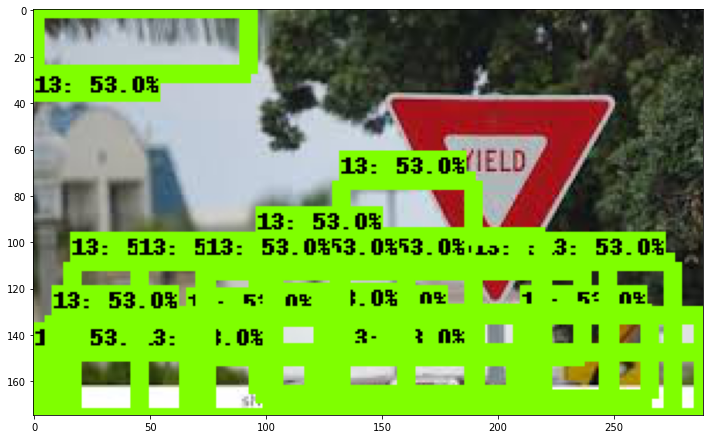

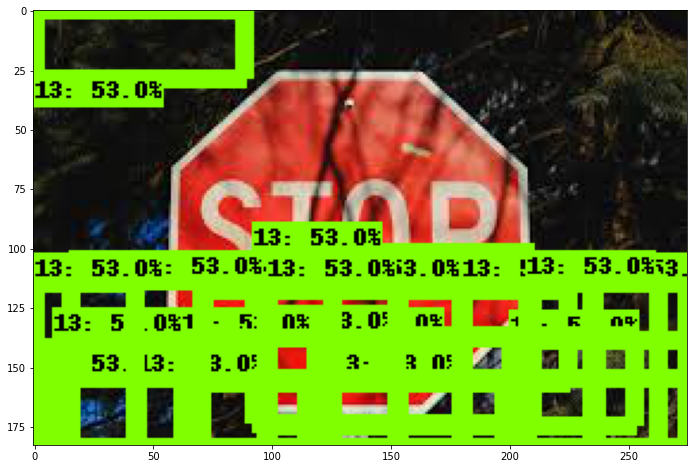

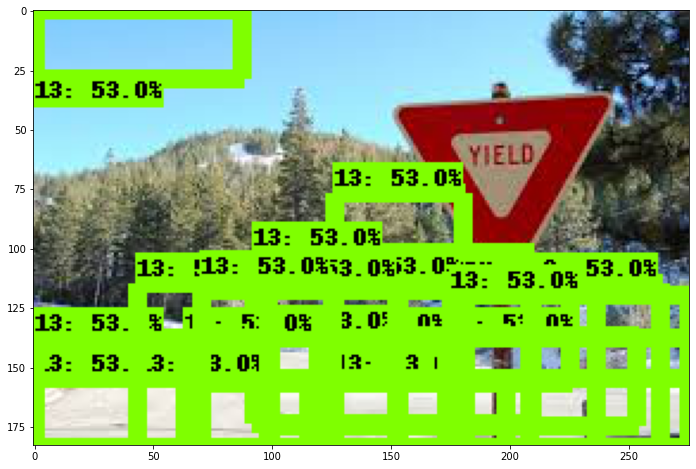

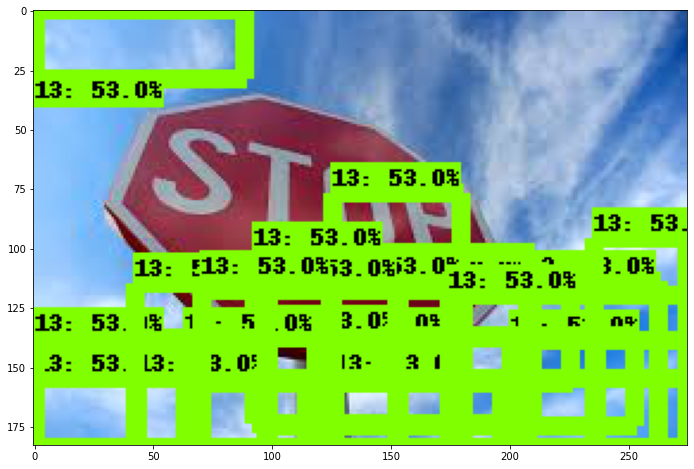

In [134]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)